In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 671 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
#import requests
import csv
import os
from datetime import datetime, timedelta

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.compat.v1 import set_random_seed


#from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras. utils.vis_utils import plot_model

# SQL Alchemy
from sqlalchemy import create_engine
#from config import username, password

import warnings
warnings.filterwarnings('ignore')

import pickle

plt.style.use('fivethirtyeight')



In [3]:
start = "2010-01-01"
ticker = "TSLA"

In [4]:
import yfinance as yf
data = yf.download(ticker, start = start, period = "ytd")
#data_DF = yf.download(ticker, period = "ytd", group_by = 'ticker')

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000
2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000
2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500


In [6]:
data = data.reset_index(level=0)

In [7]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3119,2022-11-16,191.509995,192.570007,185.660004,186.919998,186.919998,66567600
3120,2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000
3121,2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900
3122,2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92650600


In [8]:
print(len(data))

3124


In [9]:
df_ticker= data.drop_duplicates()
print(df_ticker.count())

Date         3124
Open         3124
High         3124
Low          3124
Close        3124
Adj Close    3124
Volume       3124
dtype: int64


In [10]:
# Rename the columns
df_ticker = df_ticker.rename(columns={
'Date': 'Date',  
'Open': 'open',
'High': 'high',
'Low': 'low',
'Close': 'close',
'Adj Close': 'adjclose',
'Volume': 'volume'
})

In [11]:
df_ticker.dtypes

Date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
adjclose           float64
volume               int64
dtype: object

In [12]:
print('Number of rows and columns: ', df_ticker.shape)
print(df_ticker.head())
print("checking if any null values are present\n", df_ticker.isna().sum())

Number of rows and columns:  (3124, 7)
        Date      open      high       low     close  adjclose     volume
0 2010-06-29  1.266667  1.666667  1.169333  1.592667  1.592667  281494500
1 2010-06-30  1.719333  2.028000  1.553333  1.588667  1.588667  257806500
2 2010-07-01  1.666667  1.728000  1.351333  1.464000  1.464000  123282000
3 2010-07-02  1.533333  1.540000  1.247333  1.280000  1.280000   77097000
4 2010-07-06  1.333333  1.333333  1.055333  1.074000  1.074000  103003500
checking if any null values are present
 Date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64


In [13]:
df_ticker.to_csv(f'/content/{ticker}.csv', sep=',', index=True)

Loading ticker data to sqlite stocks database

In [14]:
# Create Engine for project4 data
import sqlite3 as sl
conn=create_engine("sqlite:////content/stocks.db")

In [15]:
#uploading to respecive tables in project2 database
df_ticker.to_sql(ticker, con=conn, if_exists='replace', index=False)

In [ ]:
# get treasury data
# merging two csv files
df_treasury = pd.concat(
    map(pd.read_csv, ['daily-treasury-rates.csv', 'yield-curve-rates-1990-2021.csv']), ignore_index=True)
print(df_treasury)

In [ ]:
df_treasury.dtypes

Date      object
1 Mo     float64
2 Mo     float64
3 Mo     float64
4 Mo     float64
6 Mo     float64
1 Yr     float64
2 Yr     float64
3 Yr     float64
5 Yr     float64
7 Yr     float64
10 Yr    float64
20 Yr    float64
30 Yr    float64
dtype: object

In [ ]:
df_treasury['Date'] = pd.to_datetime(df_treasury['Date'])

In [ ]:
df_treasury.dtypes

Date     datetime64[ns]
1 Mo            float64
2 Mo            float64
3 Mo            float64
4 Mo            float64
6 Mo            float64
1 Yr            float64
2 Yr            float64
3 Yr            float64
5 Yr            float64
7 Yr            float64
10 Yr           float64
20 Yr           float64
30 Yr           float64
dtype: object

In [ ]:
df_treasury

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2022-11-18,3.93,4.23,4.34,4.46,4.61,4.74,4.51,4.28,3.99,3.92,3.82,4.13,3.92
1,2022-11-17,3.93,4.20,4.32,4.44,4.57,4.68,4.43,4.22,3.93,3.87,3.77,4.10,3.89
2,2022-11-16,3.81,4.15,4.32,4.43,4.54,4.62,4.35,4.13,3.83,3.77,3.67,4.03,3.85
3,2022-11-15,3.77,4.10,4.31,4.40,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98
4,2022-11-14,3.72,4.05,4.34,4.38,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8224,1990-01-08,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8225,1990-01-05,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8226,1990-01-04,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8227,1990-01-03,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04


In [ ]:
# Finally, merge all tables
df = pd.merge(df_ticker, df_treasury, how='inner', on='Date')
df

,Date,open,high,low,close,adjclose,volume,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,0.05,NaN,0.08,NaN,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800,0.03,NaN,0.07,NaN,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,0.03,NaN,0.06,NaN,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200,0.02,NaN,0.05,NaN,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,0.02,NaN,0.05,NaN,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100,3.72,4.05,4.34,4.38,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07
3216,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300,3.77,4.10,4.31,4.40,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98
3217,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300,3.81,4.15,4.32,4.43,4.54,4.62,4.35,4.13,3.83,3.77,3.67,4.03,3.85
3218,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80389400,3.93,4.20,4.32,4.44,4.57,4.68,4.43,4.22,3.93,3.87,3.77,4.10,3.89


In [ ]:
# Find null values
for column in df.columns:
    print(f"Column {column} has {df[column].isnull().sum()} null values")

Column Date has 0 null values
Column open has 0 null values
Column high has 0 null values
Column low has 0 null values
Column close has 0 null values
Column adjclose has 0 null values
Column volume has 0 null values
Column 1 Mo has 1 null values
Column 2 Mo has 2197 null values
Column 3 Mo has 1 null values
Column 4 Mo has 3198 null values
Column 6 Mo has 1 null values
Column 1 Yr has 1 null values
Column 2 Yr has 1 null values
Column 3 Yr has 1 null values
Column 5 Yr has 1 null values
Column 7 Yr has 1 null values
Column 10 Yr has 1 null values
Column 20 Yr has 1 null values
Column 30 Yr has 1 null values


In [ ]:
df = df.drop(columns =["4 Mo"])
df.head(15)

,Date,open,high,low,close,adjclose,volume,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396484,462229600,0.01,NaN,0.04,0.13,0.35,0.95,1.55,2.58,3.32,3.85,4.64,4.74
6,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323724,594459600,0.02,NaN,0.05,0.14,0.34,0.92,1.50,2.49,3.22,3.74,4.52,4.62
7,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412925,605892000,0.02,NaN,0.06,0.15,0.37,0.97,1.54,2.55,3.28,3.80,4.60,4.71
8,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375782,432894000,0.02,NaN,0.05,0.14,0.34,0.94,1.49,2.51,3.23,3.76,4.52,4.63
9,2010-01-15,7.533214,7.557143,7.352500,7.354643,6.269229,594067600,0.03,NaN,0.06,0.15,0.33,0.89,1.44,2.44,3.17,3.70,4.48,4.58


In [ ]:
# Find duplicate entries
print(f"Duplicate entries: {df.duplicated().sum()}")

Duplicate entries: 0


In [ ]:
# Renaming the columns
df = df.rename(columns={
'Date': 'date',
'1 Mo': '1mo',
'2 Mo': '2mo',
'3 Mo': '3mo',
'6 Mo': '6mo',
'Year': 'year',
'1 Yr': '1yr',
'2 Yr': '2yr',
'3 Yr': '3yr',
'5 Yr': '5yr',
'7 Yr': '7yr',
'10 Yr': '10yr',
'20 Yr': '20yr',
'30 Yr': '30yr'
})

In [ ]:
#df = pd.DataFrame(df)

In [ ]:
df = df.set_index('date')

In [ ]:
df.to_csv(f'/content/{ticker}.csv', sep=',', index=True)

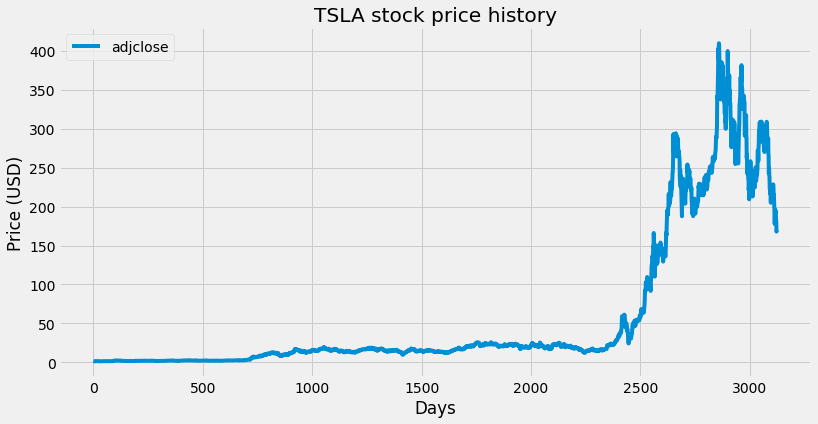

In [18]:
plt.figure(figsize = (12,6))
#plt.plot(df_ticker["open"])
#plt.plot(df_ticker["high"])
#plt.plot(df_ticker["low"])
plt.plot(df_ticker["adjclose"])
title_name = ticker+ ' stock price history'
plt.title(title_name)
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['adjclose'], loc='upper left')
#plt.legend(['Open','High','Low','adjclose'], loc='upper left')
plt.show()

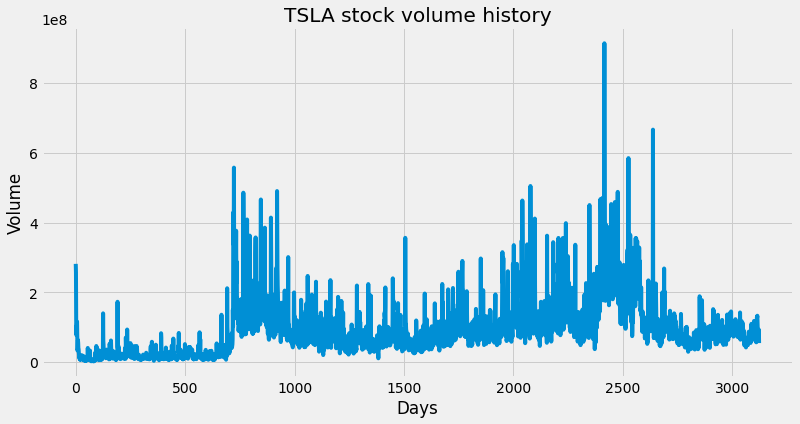

In [19]:
plt.figure(figsize = (12,6))
plt.plot(df_ticker["volume"])
title_name = ticker+ ' stock volume history'
plt.title(title_name)
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

#LSTM - Method - 1

In [ ]:
#Set Target Variable
output_var = pd.DataFrame(df["adjclose"])
#Selecting the Features
#features = ['open', 'high', 'low', 'volume', '1mo', '2mo', '3mo', '6mo', '1yr', '10yr']
features = ['open', 'high', 'low', 'volume']

NameError: ignored

In [ ]:
#df = df.reset_index(level=0)

In [ ]:
df.head(10)

NameError: ignored

In [ ]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

#Splitting to Training set and Test set
The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 10, indicating that 10% of the data will be used as the test set and 90% of the data would be used to train the LSTM model. The advantage of utilising this Time Series split is that the split time series data samples are examined at regular time intervals.

In [ ]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

NameError: ignored

As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match into the format (Number of Samples, 1, Number of Features). 

In [ ]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

NameError: ignored

In [ ]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)



In [ ]:
print('Number of rows and columns: ', X_train.shape)

# Training the Stock Market Prediction Model

In [ ]:
# Fitting the Training set
history= lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

NameError: ignored

In [ ]:
y_pred.shape

NameError: ignored

In [ ]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

In [ ]:
#Predicted vs True Adj Close Value – LSTM
predicted_df = pd.DataFrame(y_test)
predicted_df['predictions'] = y_pred
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [ ]:
predicted_df

In [ ]:
lstm.save("LSTM_Method_1.h5")

#LSTM - Method-2

In [ ]:
# Create a dataframe with only the Close Stock Price Column
data_target = df.filter(['close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = int(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.00447776],
       [0.00455321],
       [0.00385789],
       ...,
       [0.81033515],
       [0.82135425],
       [0.82460854]])

In [ ]:
# Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 output)

Number of rows and columns:  (2235, 180, 1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 180, 50)           10400     
                                                                 
 dropout_9 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_15 (LSTM)              (None, 180, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_16 (LSTM)              (None, 180, 50)           20200     
                                                                 
 dropout_11 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_17 (LSTM)              (None, 50)               

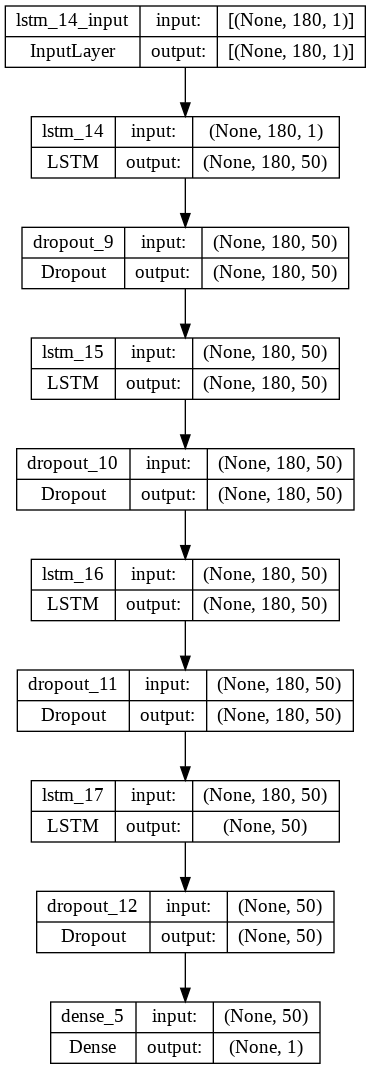

In [ ]:
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# 50 units which is the dimensionality of the output space
# return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit.
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['accuracy'])

# Reporting the number of parameters
print(model.summary())
    
num_params = model.count_params()
print('Number of parameters: {}'.format(num_params))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
70/70 [==============================] - 25s 275ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 2/100
70/70 [==============================] - 17s 246ms/step - loss: 3.3258e-04 - accuracy: 0.0000e+00
Epoch 3/100
70/70 [==============================] - 17s 244ms/step - loss: 2.4371e-04 - accuracy: 0.0000e+00
Epoch 4/100
70/70 [==============================] - 18s 254ms/step - loss: 2.4255e-04 - accuracy: 0.0000e+00
Epoch 5/100
70/70 [==============================] - 17s 245ms/step - loss: 2.1916e-04 - accuracy: 0.0000e+00
Epoch 6/100
70/70 [==============================] - 17s 249ms/step - loss: 1.8092e-04 - accuracy: 0.0000e+00
Epoch 7/100
70/70 [==============================] - 17s 247ms/step - loss: 1.6726e-04 - accuracy: 0.0000e+00
Epoch 8/100
70/70 [==============================] - 17s 246ms/step - loss: 1.8128e-04 - accuracy: 0.0000e+00
Epoch 9/100
70/70 [==============================] - 18s 254ms/step - loss: 1.5294e-04 - accuracy: 0.0000e+00
Epoch 10/100
7

In [ ]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 180: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (805, 180, 1)


In [ ]:
# Making predictions using the test dataset
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

26/26 [==============================] - 1s 52ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


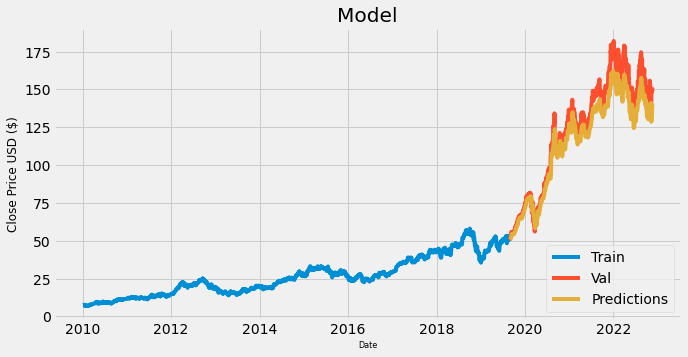

In [ ]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,close,predictions
date,,
2019-08-30,52.185001,50.668907
2019-09-03,51.424999,50.973366
2019-09-04,52.297501,51.222363
2019-09-05,53.320000,51.427631
2019-09-06,53.314999,51.746700
...,...,...
2022-11-14,148.279999,131.436844
2022-11-15,150.039993,135.554764
2022-11-16,148.789993,139.273193


In [ ]:
#save models
model.save("LSTM_Method_2.h5")

# Stock price prediction - ARIMA model
 

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
## Add a dummy row at the end. This will not be used to predict. 

df_ticker.loc[len(df_ticker)]=df_ticker.loc[len(df_ticker)-1]

next_day = datetime.now()+timedelta(1)
df_ticker.iloc[-1, df_ticker.columns.get_loc('Date')] = next_day
df_ticker['Date'] = pd.to_datetime(df_ticker["Date"]).dt.date

In [22]:
df_ticker = df_ticker.set_index('Date')

In [ ]:
#df_ticker = df_ticker.reset_index(level=0)

In [23]:
df_ticker

,open,high,low,close,adjclose,volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000
2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900
2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92650600


In [24]:
df_ticker.tail()
df_ticker['avg'] = (df_ticker['high'] + df_ticker['low']) / 2
df_ticker.tail()

,open,high,low,close,adjclose,volume,avg
Date,,,,,,,
2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000,183.529999
2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900,180.870003
2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92650600,172.154999
2022-11-22,168.630005,170.919998,166.184998,169.322693,169.322693,54298462,168.552498
2022-11-23,168.630005,170.919998,166.184998,169.322693,169.322693,54298462,168.552498


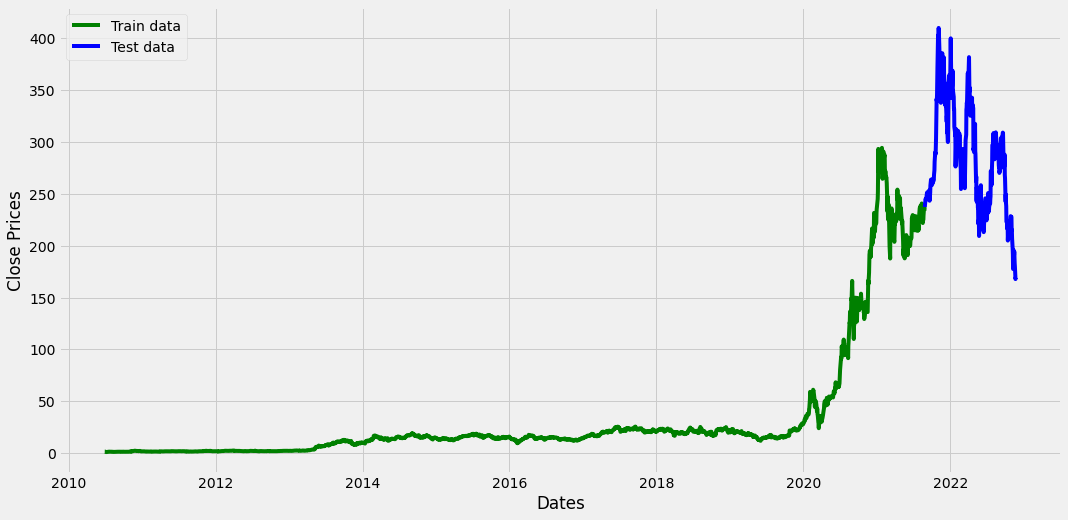

In [25]:
train_data, test_data = df_ticker[0:int(len(data)*0.9)], df_ticker[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_data['close'], 'green', label='Train data')
plt.plot(test_data['close'], 'blue', label='Test data')
plt.legend()

#ARIMA (Autoregressive integrated moving average) Model

In [26]:
train_arima = train_data['avg']
test_arima = test_data['close']

In [27]:
train_arima

Date
2010-06-29      1.418000
2010-06-30      1.790667
2010-07-01      1.539667
2010-07-02      1.393667
2010-07-06      1.194333
                 ...    
2021-08-20    227.638336
2021-08-23    232.146667
2021-08-24    236.309998
2021-08-25    236.828339
2021-08-26    235.503326
Name: avg, Length: 2811, dtype: float64

In [28]:
history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))
accuracy = r2_score(y, predictions)
print('Accuracy:'+str(accuracy))

MSE: 134.24261181452468
MAE: 8.45411228175581
RMSE: 11.586311398133777
Accuracy:0.9501638323937261


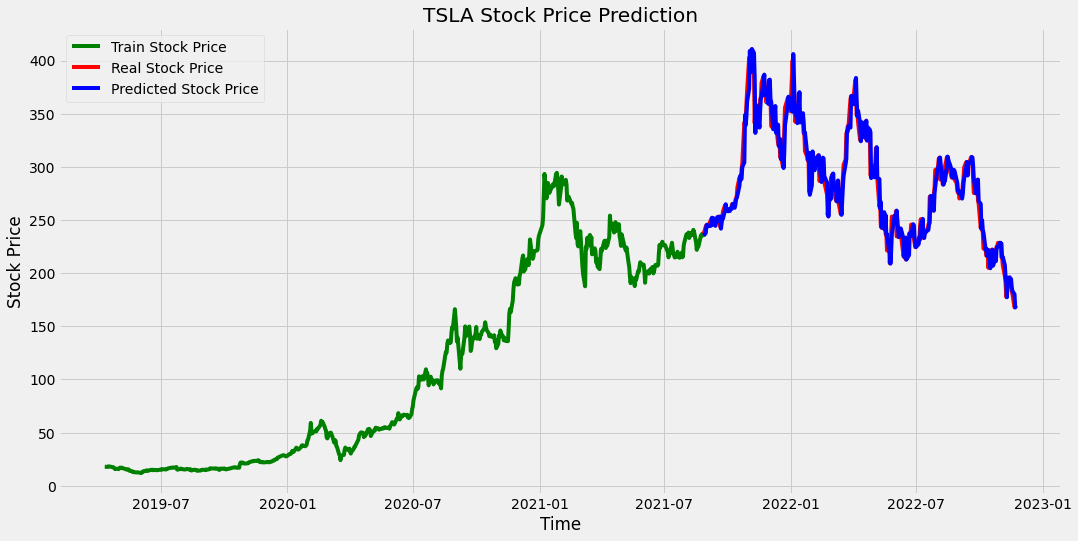

In [29]:
plt.figure(figsize=(16,8))
plt.plot(train_data.index[-600:], train_data['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
title_name = ticker+ ' Stock Price Prediction'
plt.title(title_name)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [30]:
df_pred = pd.DataFrame(test_data.index)
df_pred['predictions'] = predictions
df_pred

,Date,predictions
0,2021-08-27,[235.35165151135843]
1,2021-08-30,[237.67715167069682]
2,2021-08-31,[244.76827856453244]
3,2021-09-01,[245.58098373031666]
4,2021-09-02,[244.67761389841834]
...,...,...
309,2022-11-17,[186.84502613041445]
310,2022-11-18,[183.15857817687052]
311,2022-11-21,[180.1910832140838]
312,2022-11-22,[167.68585209993765]


In [31]:
print("Tomorrow's predicted stock price = $", float(predictions[-1]))

Tomorrow's predicted stock price = $ 169.40278715926792


In [ ]:
#save models
model.save("ARIMA_Model.h5")